In [15]:
import os
import torch
from torch import nn
import torchvision
import matplotlib.pyplot as plt
from models.FCN import get_FCN
from dataloaders.VOCSegmentation import load_VOCSegmentation, read_voc_images, label2image
from tools.model_trainer import train_model
from tools.utils import show_images

In [2]:
batch_size, crop_size = 2, (320, 480)
train_iter, test_iter = load_VOCSegmentation(batch_size, crop_size)
print(f"Size of Trian Set: {len(train_iter)}")
print(f"Size of Test Set: {len(test_iter)}")
for X, y in test_iter:
    print(X.shape, y.shape)
    break

Size of Trian Set: 557
Size of Test Set: 539
torch.Size([2, 3, 320, 480]) torch.Size([2, 320, 480])


In [3]:
net = get_FCN(num_classes=21)

In [4]:
def loss(inputs, targets):
    from torch.nn import functional as F
    return F.cross_entropy(inputs, targets, reduction='none').mean(1).mean(1)



num_epochs, lr, wd = 2, 0.001, 1e-3
device =  'cuda' if torch.cuda.is_available() else 'cpu'
print(f'device: {device}')
trainer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=wd)

train_model(net, train_iter, test_iter, loss, ['accuracy'], trainer, num_epochs, device, multlabel=True)


device: cuda
training on cuda
Epoch 1/2
557/557 [===============] Train Loss: 1.2200, Train Accuracy: 0.7328, Valid Loss: 0.8326, Valid Accuracy: 0.7874, Cost Time 17.0431 sec
Epoch 2/2
557/557 [===============] Train Loss: 0.9451, Train Accuracy: 0.7703, Valid Loss: 0.6904, Valid Accuracy: 0.8116, Cost Time 17.0174 sec
Train result
loss 0.9451
final train Accuracy 0.7703
final valid Accuracy 0.8116
65.4130 examples/sec on cuda
17.0303 sec/epoch on cuda


In [5]:
from tools.model_tester import test_model
test_model(net, test_iter, loss, ["accuracy"], device)

Test result
Number of instances: 1078
Number of batches: 539
Size of an element: 165580800.0
Avg loss of each instance: 0.701874
Accuracy: 0.8097
Time spent: 3.7232534885406494 sec
289.5317 examples/sec
0.0069 sec/batch on cuda


(0.7018743783567302, [0.8097174189277984])

In [5]:
batch_size, crop_size = 32, (320, 480)
train_iter, test_iter = load_VOCSegmentation(batch_size, crop_size)
net = get_FCN(num_classes=21)
num_epochs, lr, wd = 10, 0.001, 1e-3
device =  'cuda' if torch.cuda.is_available() else 'cpu'
print(f'device: {device}')
trainer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=wd)

train_model(net, train_iter, test_iter, loss, ['accuracy'], trainer, num_epochs, device, multlabel=True)

device: cuda
training on cuda
Epoch 1/10
34/34 [===============] Train Loss: 1.1446, Train Accuracy: 0.7455, Valid Loss: 0.6860, Valid Accuracy: 0.7995, Cost Time 7.2649 sec
Epoch 2/10
34/34 [===============] Train Loss: 0.6137, Train Accuracy: 0.8279, Valid Loss: 0.5549, Valid Accuracy: 0.8204, Cost Time 7.2424 sec
Epoch 3/10
34/34 [===============] Train Loss: 0.5131, Train Accuracy: 0.8464, Valid Loss: 0.5168, Valid Accuracy: 0.8259, Cost Time 7.2476 sec
Epoch 4/10
34/34 [===============] Train Loss: 0.4550, Train Accuracy: 0.8600, Valid Loss: 0.4862, Valid Accuracy: 0.8313, Cost Time 7.2351 sec
Epoch 5/10
34/34 [===============] Train Loss: 0.4142, Train Accuracy: 0.8698, Valid Loss: 0.4807, Valid Accuracy: 0.8313, Cost Time 7.2427 sec
Epoch 6/10
34/34 [===============] Train Loss: 0.3807, Train Accuracy: 0.8781, Valid Loss: 0.4634, Valid Accuracy: 0.8346, Cost Time 7.2460 sec
Epoch 7/10
34/34 [===============] Train Loss: 0.3513, Train Accuracy: 0.8865, Valid Loss: 0.4526, Valid A

In [6]:
def predict(img):
    X = test_iter.dataset.normalize_image(img).unsqueeze(0)
    pred = net(X.to(device)).argmax(dim=1)
    return pred.reshape(pred.shape[1], pred.shape[2])

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

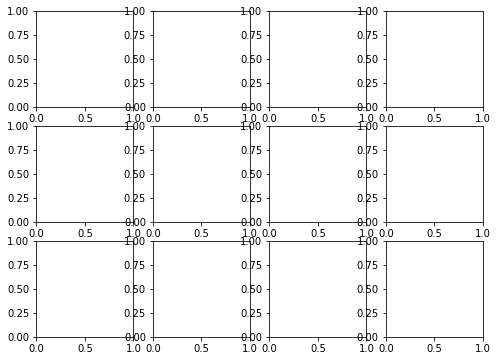

In [22]:
voc_dir = "./Datasets/VOCdevkit/VOC2012"
test_images, test_labels = read_voc_images(voc_dir, False)
n, imgs = 4, []
for i in range(100, n+4):
    crop_rect = (0, 0, 320, 480)
    X = torchvision.transforms.functional.crop(test_images[i], *crop_rect)
    pred = label2image(predict(X))
    imgs += [X.permute(1,2,0), pred.cpu(),
             torchvision.transforms.functional.crop(
                 test_labels[i], *crop_rect).permute(1,2,0)]
show_images(imgs[::3] + imgs[1::3] + imgs[2::3], 3, n, scale=2)